# Question 1: Decoder Model

In [1]:
import torch
import json
import os
import re
import unicodedata
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from fpdf import FPDF
from tqdm import tqdm

In [2]:
# Load datasets
def load_dataset(file_path):
    """Load a JSON file and return the dataset."""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} jokes from {file_path}")
    return data

# Combine them
def combine_datasets(file_paths):
    """Combine multiple datasets into one."""
    combined = []
    for file_path in file_paths:
        combined.extend(load_dataset(file_path))
    print(f"Combined dataset contains {len(combined)} jokes in total.")
    return combined

# Preprocess jokes
def preprocess_jokes(jokes, min_length= 5, profanity_filter=True):
    """
    Preprocess jokes by cleaning text, filtering invalid entries, and addressing duplicates.

    Args:
        jokes (list): List of jokes, where each joke is a dictionary with keys like 'body', 'title', 'id', 'score'.
        min_score (int): Minimum score to include a joke.
        min_length (int): Minimum length of the body and title to include a joke.
        profanity_filter (bool): Whether to censor profanities in the jokes.

    Returns:
        list: A list of processed jokes with cleaned and valid entries.
    """
    processed = []
    seen_bodies = set()

    # Clean Unicode characters
    def clean_unicode(text):
        text = unicodedata.normalize("NFKD", text)
        return text.encode("ascii", "ignore").decode("ascii")

    # # Function to censor profanity
    # def censor_profanity(text):
    #     profanities = ["fuck", "shit", "damn", "asshole", "bitch", "jew", "dick"]  # Extend list as needed
    #     for word in profanities:
    #         text = re.sub(fr"\b{word}\b", "*" * len(word), text, flags=re.IGNORECASE)
    #     return text

    for joke in jokes:
        # Safely retrieve fields
        body = joke.get("body", "").strip()
        title = joke.get("title", "").strip()
        score = joke.get("score", 0)
        joke_id = joke.get("id", "unknown")

        body = clean_unicode(body)
        title = clean_unicode(title)

        # Normalize whitespace and remove special characters
        body = re.sub(r'[\n\t\r]+', ' ', body).strip()
        title = re.sub(r'[\n\t\r]+', ' ', title).strip()

        # Replace multiple spaces with a single space
        body = re.sub(r'\s{2,}', ' ', body)
        title = re.sub(r'\s{2,}', ' ', title)

        # # Censor profanities
        # if profanity_filter:
        #     body = censor_profanity(body)
        #     title = censor_profanity(title)

        # Skip short jokes
        if len(body) < min_length or len(title) < min_length:
            continue

        # Add cleaned joke to the processed list
        processed.append({
            "body": body,
            "title": title,
            "id": joke_id,
            "score": score
        })

    print(f"Processed dataset contains {len(processed)} valid jokes after filtering.")
    return processed

# Split dataset into train, validation, and test sets
def split_dataset(jokes, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    train, temp = train_test_split(jokes, test_size=(1 - train_ratio), random_state=42)
    val, test = train_test_split(temp, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

    print(f"Training set: {len(train)} jokes")
    print(f"Validation set: {len(val)} jokes")
    print(f"Test set: {len(test)} jokes")

    return train, val, test

# Save splits to files
def save_splits(train, val, test, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    with open(os.path.join(output_dir, 'train.json'), 'w', encoding='utf-8') as f:
        json.dump(train, f, indent=4)

    with open(os.path.join(output_dir, 'val.json'), 'w', encoding='utf-8') as f:
        json.dump(val, f, indent=4)

    with open(os.path.join(output_dir, 'test.json'), 'w', encoding='utf-8') as f:
        json.dump(test, f, indent=4)

    print(f"Saved train, validation, and test splits to {output_dir}")


def main():
    ### MENTION THE FILEPATHS CORRECTLY ###
    ### MENTION THE FILEPATHS CORRECTLY ###
    file_paths = ['reddit_jokes.json', 'stupidstuff.json', 'wocka.json']
    combined_dataset = combine_datasets(file_paths)
    processed_dataset = preprocess_jokes(combined_dataset)
    train, val, test = split_dataset(processed_dataset)
    save_splits(train, val, test, output_dir='joke_splits')

if __name__ == "__main__":
    main()


Loaded 194553 jokes from reddit_jokes.json
Loaded 3773 jokes from stupidstuff.json
Loaded 10019 jokes from wocka.json
Combined dataset contains 208345 jokes in total.
Processed dataset contains 198107 valid jokes after filtering.
Training set: 158485 jokes
Validation set: 19811 jokes
Test set: 19811 jokes
Saved train, validation, and test splits to joke_splits


In [3]:
class JokeDataset(Dataset):
    def __init__(self, file_path: str, max_vocab: int, sequence_limit: int = 128):
        """
        Initialize the dataset by loading and preprocessing jokes.
        """
        with open(file_path, 'r') as f:
            self.records = json.load(f)
        
        self.sequence_limit = sequence_limit
        self.max_vocab = max_vocab
        self.word_to_index = self.generate_vocab()
        self.index_to_word = {i: w for w, i in self.word_to_index.items()}

        # Special token IDs
        self.pad_id = self.word_to_index.get("<pad>", 0)
        self.end_id = self.word_to_index.get("<eos>", 1)
    
    def generate_vocab(self):
        """
        Construct a vocabulary based on word frequency.
        """
        word_count = Counter()
        for joke in self.records:
            word_count.update(joke["body"].split())
        
        # Limit the vocabulary size and reserve space for special tokens
        vocab = {word: idx for idx, (word, _) in enumerate(word_count.most_common(self.max_vocab - 2), start=2)}
        vocab["<pad>"] = 0
        vocab["<eos>"] = 1
        return vocab

    def __getitem__(self, index: int):
        """
        Retrieve a single example from the dataset.
        """
        text = self.records[index]["body"]
        tokens = self.tokenize(text)

        input_sequence = torch.tensor(tokens[:-1])  # Exclude the last token for inputs
        target_sequence = torch.tensor(tokens[1:])  # Shifted targets
        mask = (input_sequence != self.pad_id).float()  # Attention mask

        return {
            'input_sequence': input_sequence,
            'attention_mask': mask,
            'target_sequence': target_sequence
        }

    def __len__(self):
        return len(self.records)

    def tokenize(self, sentence: str) -> list:
        """
        Convert a sentence into token IDs with padding and EOS handling.
        """
        tokens = [self.word_to_index.get(word, 2) for word in sentence.split()]
        tokens = tokens[:self.sequence_limit - 1] + [self.end_id]

        if len(tokens) < self.sequence_limit:
            tokens += [self.pad_id] * (self.sequence_limit - len(tokens))
        return tokens

    def detokenize(self, token_ids: list) -> str:
        """
        Convert token IDs back into a readable sentence.
        """
        words = [self.index_to_word.get(tid, "<unk>") for tid in token_ids]
        
        eos_pos = np.where(token_ids == self.end_id)[0]
        
        if eos_pos.size > 0:
            eos_pos = eos_pos[0]
            words = words[:eos_pos]
        
        return " ".join(words)


In [4]:
class JokeGenerator(nn.Module):
    def __init__(self, vocab_capacity: int, seq_limit: int = 128, embed_dim: int = 256,
                 layers: int = 4, heads: int = 8, feedforward_dim: int = 512, dropout_rate: float = 0.1):
        super().__init__()
        self.seq_limit = seq_limit

        self.word_embedding = nn.Embedding(vocab_capacity, embed_dim)
        self.positional_embedding = nn.Parameter(torch.randn(1, seq_limit, embed_dim))

        self.decoder_stack = nn.ModuleList([
            DecoderUnit(embed_dim, heads, feedforward_dim, dropout_rate)
            for _ in range(layers)
        ])

        self.dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(embed_dim, vocab_capacity)

    def forward(self, input_tokens: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        batch_size, seq_length = input_tokens.size()

        causal_mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(input_tokens.device)

        embeddings = self.word_embedding(input_tokens)
        embeddings += self.positional_embedding[:, :seq_length, :]
        embeddings = self.dropout(embeddings)

        for decoder in self.decoder_stack:
            embeddings = decoder(embeddings, causal_mask)

        output_logits = self.output_layer(embeddings)
        return output_logits


class DecoderUnit(nn.Module):
    def __init__(self, embed_dim: int, heads: int, feedforward_dim: int, dropout_rate: float = 0.1):
        super().__init__()
        self.self_attention = nn.MultiheadAttention(embed_dim, heads, dropout=dropout_rate, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, feedforward_dim),
            nn.GELU(),
            nn.Linear(feedforward_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        attention_output, _ = self.self_attention(inputs, inputs, inputs, attn_mask=mask)
        residual1 = inputs + self.dropout(attention_output)
        normalized1 = self.norm1(residual1)

        ff_output = self.feed_forward(normalized1)
        residual2 = normalized1 + self.dropout(ff_output)
        normalized2 = self.norm2(residual2)

        return normalized2


Using device: cuda

=== Running Experiment 1/1 ===
Hyperparameters: {'vocab_size': 30000, 'hidden_dim': 128, 'num_layers': 2, 'num_heads': 4, 'dropout': 0.2, 'max_length': 128, 'batch_size': 32, 'learning_rate': 5e-05, 'epochs': 4}

--- Epoch 1/4 ---


Training: 100%|██████████| 4953/4953 [04:00<00:00, 20.57it/s]


Epoch 1 - Training Loss: 8.2158


Validating: 100%|██████████| 620/620 [00:12<00:00, 49.17it/s]


Epoch 1 - Validation Loss: 6.9340

--- Epoch 2/4 ---


Training: 100%|██████████| 4953/4953 [04:02<00:00, 20.46it/s]


Epoch 2 - Training Loss: 6.5923


Validating: 100%|██████████| 620/620 [00:12<00:00, 48.94it/s]


Epoch 2 - Validation Loss: 7.0101

--- Epoch 3/4 ---


Training: 100%|██████████| 4953/4953 [04:02<00:00, 20.43it/s]


Epoch 3 - Training Loss: 6.3520


Validating: 100%|██████████| 620/620 [00:12<00:00, 48.99it/s]


Epoch 3 - Validation Loss: 7.1186

--- Epoch 4/4 ---


Training: 100%|██████████| 4953/4953 [04:02<00:00, 20.44it/s]


Epoch 4 - Training Loss: 6.2748


Validating: 100%|██████████| 620/620 [00:12<00:00, 49.03it/s]


Epoch 4 - Validation Loss: 7.1397
Model weights saved to model_weights.pt


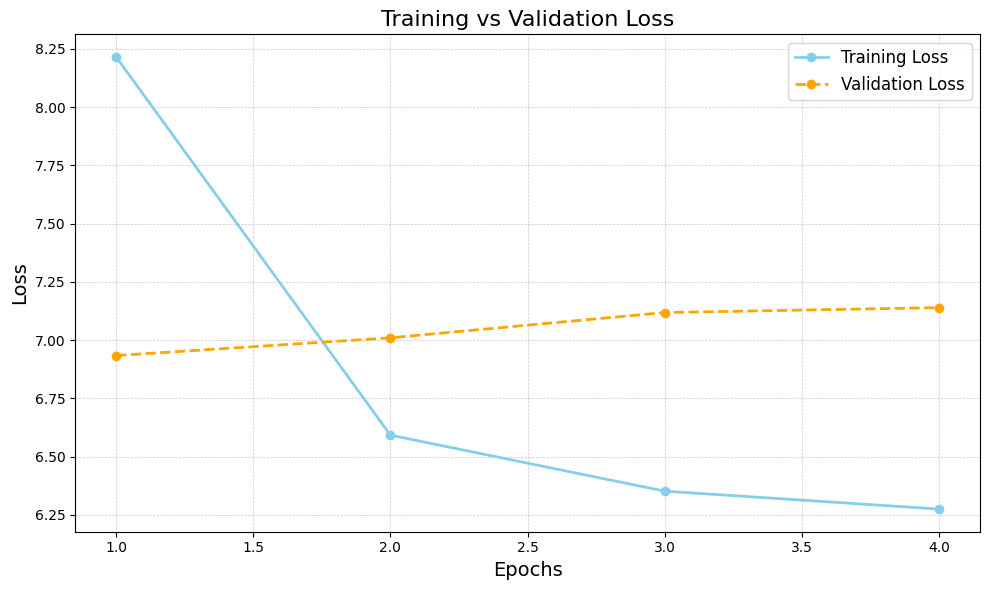

Experiment 1 Results: {'train_loss': [8.215801332879254, 6.59229887756896, 6.35201339800623, 6.274805362215433], 'val_loss': [6.934022220488518, 7.010075714511256, 7.118610152890605, 7.139653678094187]}


In [5]:
def plot_loss_curve(train_loss, val_loss):
    epochs = np.arange(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 6))
    # Plot Training Loss
    plt.plot(epochs, train_loss, label='Training Loss', color='skyblue', marker='o', markersize=6, linestyle='-', linewidth=2)
    # Plot Validation Loss
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange', marker='o', markersize=6, linestyle='--', linewidth=2)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()

# Core function to train and validate the model
def train_and_validate_model(model: nn.Module, train_data: DataLoader, val_data: DataLoader,
                             device: torch.device, epochs: int = 10, lr: float = 3e-4, save_path: str = "model_weights.pt"):
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_data), epochs=epochs)

    results = {"train_loss": [], "val_loss": []}
    true_labels, predicted_labels = [], []

    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch + 1}/{epochs} ---")
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_data, desc="Training"):
            inputs = batch['input_sequence'].to(device)
            targets = batch['target_sequence'].to(device)

            predictions = model(inputs)
            loss = F.cross_entropy(predictions.view(-1, predictions.size(-1)), targets.view(-1), ignore_index=0)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_data)
        results["train_loss"].append(avg_train_loss)
        print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_data, desc="Validating"):
                inputs = batch['input_sequence'].to(device)
                targets = batch['target_sequence'].to(device)

                predictions = model(inputs)
                loss = F.cross_entropy(predictions.view(-1, predictions.size(-1)), targets.view(-1), ignore_index=0)
                val_loss += loss.item()

                # Collect true and predicted labels for confusion matrix (NOT MADE, useless)
                _, predicted_labels_batch = torch.max(predictions, dim=-1)
                true_labels.extend(targets.view(-1).cpu().numpy())
                predicted_labels.extend(predicted_labels_batch.view(-1).cpu().numpy())

        avg_val_loss = val_loss / len(val_data)
        results["val_loss"].append(avg_val_loss)
        print(f"Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}")

    # Save model weights after training
    torch.save(model.state_dict(), save_path)
    print(f"Model weights saved to {save_path}")

    plot_loss_curve(results["train_loss"], results["val_loss"])

    return results


def hyperparameter_tuning(params_grid, train_loader, val_loader, device):
    results_log = []

    for i, params in enumerate(params_grid):
        print(f"\n=== Running Experiment {i + 1}/{len(params_grid)} ===")
        print(f"Hyperparameters: {params}")

        # Initialize model
        model = JokeGenerator(
            vocab_capacity=params["vocab_size"],
            seq_limit=params["max_length"],
            embed_dim=params["hidden_dim"],
            layers=params["num_layers"],
            heads=params["num_heads"],
            feedforward_dim=params["hidden_dim"] * 2,
            dropout_rate=params["dropout"]
        ).to(device)

        # Train and validate
        results = train_and_validate_model(
            model=model,
            train_data=train_loader,
            val_data=val_loader,
            device=device,
            epochs=params["epochs"],
            lr=params["learning_rate"]
        )

        # Log results
        results_log.append({
            "experiment": i + 1,
            "params": params,
            "results": results
        })

        print(f"Experiment {i + 1} Results: {results}")


def main():
    # Hyperparameter grid
    params_grid = [
        # {"vocab_size": 30000, "hidden_dim": 128, "num_layers": 2, "num_heads": 4, "dropout": 0.1, "max_length": 128,
        #  "batch_size": 64, "learning_rate": 4e-4, "epochs": 10},  ## Baseline try
        {"vocab_size": 30000, "hidden_dim": 128, "num_layers": 2, "num_heads": 4, "dropout": 0.2, "max_length": 128,
        "batch_size": 32, "learning_rate": 5e-5, "epochs": 4}, #Experiment 1 (Lower Learning Rate and Increased Dropout)
        # {"vocab_size": 30000, "hidden_dim": 128, "num_layers": 4, "num_heads": 8, "dropout": 0.2, "max_length": 128,
        # "batch_size": 32, "learning_rate": 2e-4, "epochs": 5}, #Experiment 2 (More Layers and Heads, Lower Learning Rate)
        # {"vocab_size": 30000, "hidden_dim": 128, "num_layers": 2, "num_heads": 4, "dropout": 0.3, "max_length": 128,
        # "batch_size": 16, "learning_rate": 1e-4, "epochs": 5}, #Experiment 3 (Increased Dropout and Smaller Batch Size)
        # {"vocab_size": 30000, "hidden_dim": 256, "num_layers": 4, "num_heads": 8, "dropout": 0.2, "max_length": 128,
        # "batch_size": 32, "learning_rate": 2e-4, "epochs": 5}, #Experiment 4 (Increase Layers and Heads with Slightly Lower Learning Rate)
    ]   


    # Dataset paths
    ### ADD THE FILEPATH HERE ###
    ### ADD THE FILEPATH HERE ###
    train_file = 'joke_splits/train.json'
    validation_file = 'joke_splits/val.json'

    train_dataset = JokeDataset(train_file, params_grid[0]["vocab_size"], params_grid[0]["max_length"])
    val_dataset = JokeDataset(validation_file, params_grid[0]["vocab_size"], params_grid[0]["max_length"])
    train_loader = DataLoader(train_dataset, batch_size=params_grid[0]["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params_grid[0]["batch_size"])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Perform hyperparameter tuning
    hyperparameter_tuning(params_grid, train_loader, val_loader, device)


if __name__ == "__main__":
    main()

In [13]:
# Loading the model
def load_trained_model(model_instance, file_path: str, execution_device: torch.device):
    model_instance.load_state_dict(torch.load(file_path))
    model_instance.to(execution_device)
    model_instance.eval()

# Function to make predictions on a given dataset
def generate_test_predictions(trained_model, data_loader, device_used, max_samples: int = 10):
    generated_texts = []
    trained_model.eval()

    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc='Evaluating'):
            # Use 'input_sequence' instead of 'input_ids'
            ids_input = batch_data['input_sequence'].to(device_used)
            mask_attention = batch_data['attention_mask'].to(device_used)
            
            # Forward pass through the trained model
            model_outputs = trained_model(ids_input, mask=mask_attention)
            
            # Identify the most likely token for each position
            next_tokens = torch.argmax(model_outputs, dim=-1)  # Get the most likely token

            # Decode the output tokens
            for idx in range(ids_input.shape[0]):
                decoded_output = data_loader.dataset.detokenize(next_tokens[idx].cpu().numpy())
                generated_texts.append(decoded_output)
                
                if len(generated_texts) >= max_samples:
                    break
            if len(generated_texts) >= max_samples:
                break
    return generated_texts


# function to test the model on a dataset
def evaluate_model_on_testset(dataset_path: str, model_file: str, token_vocab_size: int = 30000, seq_length: int = 128, loader_batch_size: int = 64):
    test_data = JokeDataset(dataset_path, token_vocab_size, seq_length)
    test_data_loader = DataLoader(test_data, batch_size=loader_batch_size)

    device_in_use = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #ADJUST THESE YOURSELF BASED ON THE HYPERPARAMETERS YOU HAVE GIVEN ABOVE!
    #ADJUST THESE YOURSELF BASED ON THE HYPERPARAMETERS YOU HAVE GIVEN ABOVE!
    joke_model = JokeGenerator(
        vocab_capacity=token_vocab_size, # ADJUST
        seq_limit=seq_length,            # ADJUST
        embed_dim= 128,                  # ADJUST
        layers=2,                        # ADJUST
        heads=4,                         # ADJUST
        feedforward_dim=256,             # ADJUST
        dropout_rate=0.2                 # ADJUST
    )
    load_trained_model(joke_model, model_file, device_in_use)
    print(f"Model is running on: {device_in_use}")
    
    # Generate outputs and display them
    generated_predictions = generate_test_predictions(joke_model, test_data_loader, device_in_use, max_samples= 10) #max_samples=len(test_data)
    print("\nGenerated Outputs:")
    for joke_num, joke_text in enumerate(generated_predictions, 1):
        print(f"Joke {joke_num}: {joke_text}")

## MENTION FILEPATHS CORRECTLY ##
if __name__ == "__main__":
    evaluate_model_on_testset(
        dataset_path='joke_splits/test.json',
        model_file='model_weights.pt'
    )


/tmp/ipykernel_4167878/93863687.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_instance.load_state_dict(torch.load(file_path))


Model is running on: cuda


Evaluating:   0%|          | 0/310 [00:00<?, ?it/s]


Generated Outputs:
Joke 1: was I have the of was a
Joke 2: was
Joke 3: of
Joke 4: was
Joke 5: of
Joke 6: the the
Joke 7: the the
Joke 8: of
Joke 9: of
Joke 10: was a a to the was the


# Question 2: Fine-Tuned GPT2 Model

In [14]:
import os
import json
import torch
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_scheduler
from datasets import load_dataset
from tqdm import tqdm

In [8]:
# Fine-tuning function
def fine_tune_gpt2(dataset_path: str, model_save_path: str, 
                   pretrained_model: str = "gpt2", epochs: int = 3, 
                   batch_size: int = 4, learning_rate: float = 5e-5, 
                   max_length: int = 128, warmup_steps: int = 500):
    """
    Fine-tune a GPT-2 model using the dataset provided.
    
    Args:
        dataset_path (str): Path to the dataset file (JSON or text format).
        model_save_path (str): Path to save the fine-tuned model.
        pretrained_model (str): Huggingface model identifier for GPT-2.
        epochs (int): Number of epochs for training.
        batch_size (int): Batch size for DataLoader.
        learning_rate (float): Learning rate for AdamW optimizer.
        max_length (int): Maximum token length for input sequences.
        warmup_steps (int): Number of warmup steps for the scheduler.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model)
    tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a padding token
    model = GPT2LMHeadModel.from_pretrained(pretrained_model).to(device)

    # Load dataset
    dataset = load_dataset("json", data_files=dataset_path, split="train")
    print(f"Dataset loaded with {len(dataset)} samples.")

    # Tokenize dataset
    
    def tokenize_function(examples):
        # Combine title and body into a single text string
        combined_text = [f"{title}: {body}" for title, body in zip(examples["title"], examples["body"])]
        return tokenizer(combined_text, truncation=True, max_length=max_length, padding="max_length")

    
    tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["title", "body"])
    tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask"])

    train_dataloader = DataLoader(tokenized_dataset, shuffle=True, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    num_training_steps = len(train_dataloader) * epochs
    lr_scheduler = get_scheduler(
        "linear", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps
    )

    # Training loop
    model.train()
    for epoch in range(epochs):
        print(f"\n--- Epoch {epoch + 1}/{epochs} ---")
        total_loss = 0

        for batch in tqdm(train_dataloader, desc="Training"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent gradient explosion
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1} - Training Loss: {avg_loss:.4f}")

    # Save the fine-tuned model
    os.makedirs(model_save_path, exist_ok=True)
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Fine-tuned model saved to {model_save_path}")

In [9]:
with open("joke_splits/train.json", "r") as f:
    jokes = json.load(f)

# Refine the dataset
refined_jokes = []
for joke in jokes:
    # Ensure necessary fields are present and consistent
    if "title" in joke and "body" in joke:
        refined_jokes.append({
            "title": joke["title"].strip(),
            "body": joke["body"].strip()
        })

with open("refined_jokes.json", "w") as f:
    json.dump(refined_jokes, f, indent=4)

print(f"Refined dataset saved with {len(refined_jokes)} jokes.")

Refined dataset saved with 158485 jokes.


In [ ]:
if __name__ == "__main__":
    fine_tune_gpt2(
        dataset_path="refined_jokes.json",  # Replace with your dataset path
        model_save_path="fine_tuned_gpt2",
        epochs=3,
        batch_size=8,
        learning_rate=5e-5,
        max_length=128,
        warmup_steps=500
    )


In [15]:
# ADD FILE PATH PROPERLY
# ADD FILE PATH PROPERLY
model_path = "fine_tuned_gpt2"  # Path to the folder containing the fine-tuned model
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
 
# Function to generate jokes
def generate_jokes(prompt="Tell me a joke:", num_jokes=10, max_length=100):
    model.eval()
    generated_jokes = []
    
    for _ in range(num_jokes):
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
 
        # Generate output using the model
        output = model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=1,  # Generate one sequence at a time
            no_repeat_ngram_size=2,  # Prevent repeating phrases
            top_p=0.95,
            top_k=60,
            temperature=0.7,
            do_sample=True,  # Enable sampling
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
 
        # Decode and clean up the generated text
        joke = tokenizer.decode(output[0], skip_special_tokens=True)
        generated_jokes.append(joke)
    
    return generated_jokes
 
# Example usage: Generate 10 jokes
if __name__ == "__main__":
    jokes = generate_jokes(prompt="Tell me a joke:", num_jokes=10, max_length=100)
    for idx, joke in enumerate(jokes, 1):
        print(f"Joke {idx}: {joke}\n")

Joke 1: Tell me a joke: What do you call a gay cow? Beef Stroganoff

Joke 2: Tell me a joke: You should never tell a man to lick his dick.

Joke 3: Tell me a joke: What did the duck say to the man who was doing the talking? "I'm gay."

Joke 4: Tell me a joke: A woman goes to a pet store and asks for a dog. The pet clerk says, "Let's have a look." The woman asks, and the pet manager says "Can you see a picture of the dog?" The mother looks at her child and says,"Is there a hole in the fence?"

Joke 5: Tell me a joke: A man and his wife are sitting in bed together. The wife says, "I just saw a big sign on the wall that said 'Take this.'" The husband says,"No. Take this." The woman says "That's nice, I'll take it." She walks out the door and runs back into the bedroom.

Joke 6: Tell me a joke: What do you call a Mexican who is in the closet? A closet-nazi

Joke 7: Tell me a joke: A man goes to the doctor for his usual physical and he says to him "Doctor, I'm not feeling well. I've been si